In [1]:
import pandas as pd
import json
from matplotlib import pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer

In [2]:
df = pd.read_csv('../train.csv')
df.sample(5)

,id,source,sentence_1,sentence_2,label,binary-label
1265,boostcamp-sts-v1-train-1265,petition-sampled,주식 공매도제도 폐지,주식 공매도를 폐지하자,3.6,1.0
8028,boostcamp-sts-v1-train-8028,nsmc-rtt,오오 기대이상...,열 자 이상 적을 말이 없다...,0.0,0.0
6167,boostcamp-sts-v1-train-6167,slack-sampled,바닥에 떨어져있는 다육이 잎?을 줍줍 하는데 냥이가 와서 따악 앉더라능ㅋㅋ,허브동산? 다육이 동산? 과수..? 너무 부럽네요~,0.4,0.0
8262,boostcamp-sts-v1-train-8262,petition-rtt,대학교 등록금 납부시 신청 학점 만큼 등록금 납부,대학 등록금 납부 시 신청학점만큼 등록금 납부,5.0,1.0
6679,boostcamp-sts-v1-train-6679,nsmc-rtt,댓글 쓰려고 첨으로 로긴해서 리뷰씁니다.,처음으로 로그인해서 댓글을 작성하게 되어서 리뷰를 작성하게 되었습니다.,3.4,1.0


In [3]:
from koeda import EDA
eda = EDA(morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.3, alpha_rs=0.3, prob_rd=0.3)
text = "아버지가 방에 들어가신다"
result = eda(text)
print(result)
# 아버지가 정실에 들어가신다

result = eda(text, p=(0.9, 0.9, 0.9, 0.9), repetition=2)
print(result)

아바마마가 방에 들어가신다
['방가들어가신다 에아버지', '아버지 가방들어가신다 에']


In [4]:
# pandas 데이터를 가지고 그래프를 그리는 함수입니다
def draw_graph(df):
    source_binary = {source:[0, 0] for source in sorted(df['source'].unique())}
    # print(source_binary)
    # print(df.sample(10))
    # for i, item in df.iterrows():
    #     source_binary[item['source']][item['binary-label']] += 1
    # source_binary_df = pd.DataFrame(source_binary).transpose()

    # source의 분포
    df['source'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # # source별 binary label의 분포
    # source_binary_df.plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()
    # label의 분포
    df['label'].plot(kind='hist', rot=20, figsize=(8, 6))
    plt.show()
    # binary label의 분포
    df['binary-label'].value_counts().plot(kind='bar', rot=20, figsize=(8, 6))
    plt.show()

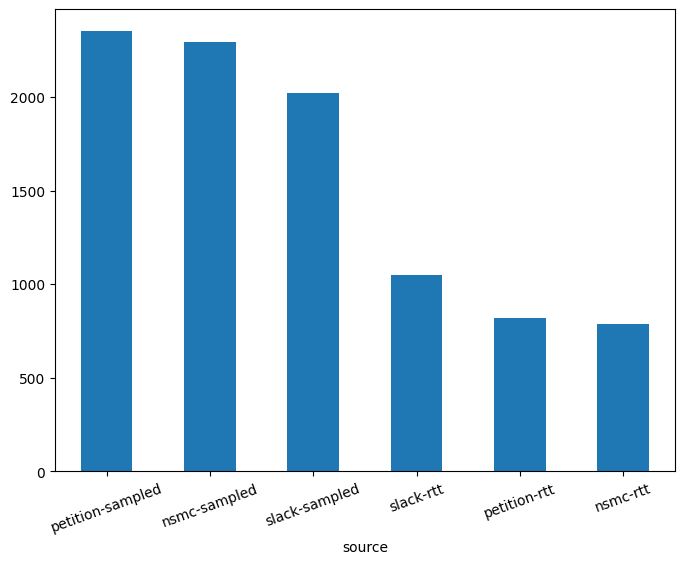

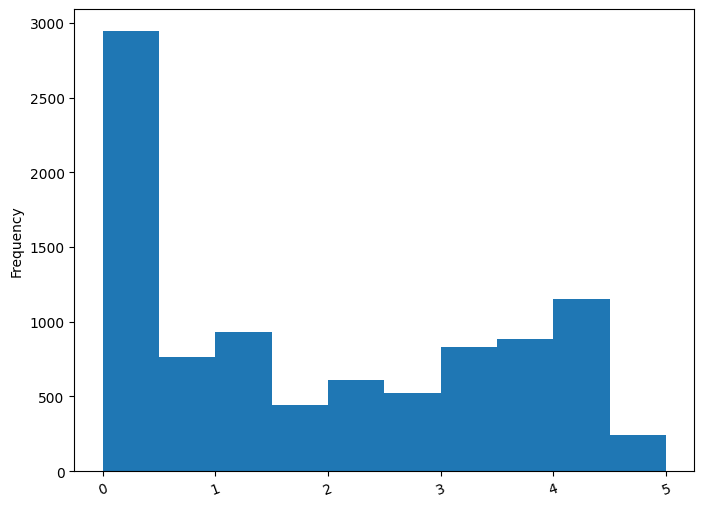

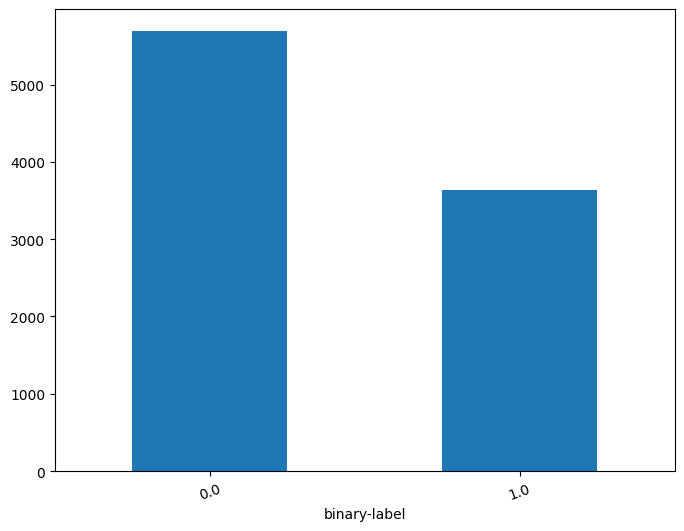

In [5]:
draw_graph(df)

In [7]:
eda = EDA(morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.3, alpha_rs=0.3, prob_rd=0.3)
model_name = 'klue/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=160)

def augment_df(df, max_len):
    augmented_data = []
    while len(augmented_data) < max_len:
        for i, row in tqdm(df.iterrows()):
            augmented_data.append([row['id'], row['sentence_1'], row['sentence_2'], row['label'], row['source'], row['binary-label']])
            augmented_sentence = eda(row['sentence_1'])
            try:
                tokenizer(augmented_sentence, add_special_tokens=True, padding='max_length', truncation=True)
                augmented_data.append([row['id'], augmented_sentence, row['sentence_2'], row['label'], row['source'], row['binary-label']])
            except:
                continue
    augmented_df = pd.DataFrame(augmented_data[:max_len], columns=['id', 'sentence_1', 'sentence_2', 'label', 'source', 'binary-label'])
    return augmented_df

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

C:\Users\Yeonsu\anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Yeonsu\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [8]:
def augment_data(df):
    # label을 기준으로 데이터를 나눕니다
    df_00 = df[df['label'] < 0.5]
    df_05 = df[(df['label'] < 1) & (0.5 <= df['label'])]
    df_10 = df[(df['label'] < 1.5) & (1.0 <= df['label'])]
    df_15 = df[(df['label'] < 2) & (1.5 <= df['label'])]
    df_20 = df[(df['label'] < 2.5) & (2 <= df['label'])]
    df_25 = df[(df['label'] < 3) & (2.5 <= df['label'])]
    df_30 = df[(df['label'] < 3.5) & (3 <= df['label'])]
    df_35 = df[(df['label'] < 4) & (3.5 <= df['label'])]
    df_40 = df[(df['label'] < 4.5) & (4 <= df['label'])]
    df_45 = df[(df['label'] < 5) & (4.5 <= df['label'])]
    
    # 데이터를 배열에 저장합니다.
    df_list = [df_00, df_05, df_10, df_15, df_20, df_25, df_30, df_35, df_40, df_45]
    max_len = max([d.shape[0] for d in df_list])
    # print(max_len) # 2946
    print([d.shape[0] for d in df_list])
    
    augmented_df = pd.DataFrame()
    for idx, d in enumerate(df_list):
        if idx == 0:
            augmented_df = pd.concat([d])
            continue
        aug_df = augment_df(d, max_len)
        augmented_df = pd.concat([augmented_df, aug_df])

    augmented_df.reset_index(drop=True, inplace=True)
    return augmented_df

In [9]:
augmented_df = augment_data(df)

[2946, 765, 928, 440, 613, 524, 832, 883, 1151, 151]


765it [00:02, 327.02it/s]
765it [00:01, 521.50it/s]
928it [00:01, 563.34it/s]
928it [00:01, 544.22it/s]
440it [00:00, 539.08it/s]
440it [00:00, 497.44it/s]
440it [00:00, 543.19it/s]
440it [00:00, 537.78it/s]
613it [00:01, 505.47it/s]
613it [00:01, 505.72it/s]
613it [00:01, 506.00it/s]
524it [00:00, 534.68it/s]
524it [00:00, 578.79it/s]
524it [00:00, 535.07it/s]
832it [00:01, 487.49it/s]
832it [00:01, 483.09it/s]
883it [00:02, 435.16it/s]
883it [00:02, 412.96it/s]
1151it [00:02, 460.45it/s]
1151it [00:02, 468.18it/s]
151it [00:00, 548.35it/s]
151it [00:00, 555.15it/s]
151it [00:00, 550.70it/s]
151it [00:00, 557.14it/s]
151it [00:00, 554.32it/s]
151it [00:00, 547.16it/s]
151it [00:00, 549.02it/s]
151it [00:00, 549.04it/s]
151it [00:00, 438.64it/s]
151it [00:00, 550.23it/s]


In [10]:
def count_len_df(df):
    # label을 기준으로 데이터를 나눕니다
    df_00 = df[df['label'] < 0.5]
    df_05 = df[(df['label'] < 1) & (0.5 <= df['label'])]
    df_10 = df[(df['label'] < 1.5) & (1.0 <= df['label'])]
    df_15 = df[(df['label'] < 2) & (1.5 <= df['label'])]
    df_20 = df[(df['label'] < 2.5) & (2 <= df['label'])]
    df_25 = df[(df['label'] < 3) & (2.5 <= df['label'])]
    df_30 = df[(df['label'] < 3.5) & (3 <= df['label'])]
    df_35 = df[(df['label'] < 4) & (3.5 <= df['label'])]
    df_40 = df[(df['label'] < 4.5) & (4 <= df['label'])]
    df_45 = df[(df['label'] < 5) & (4.5 <= df['label'])]

    # 데이터를 배열에 저장합니다.
    df_list = [df_00, df_05, df_10, df_15, df_20, df_25, df_30, df_35, df_40, df_45]
    max_len = max([d.shape[0] for d in df_list])
    # print(max_len) # 2946
    print([d.shape[0] for d in df_list])

In [11]:
count_len_df(augmented_df)

[2946, 2946, 2946, 2946, 2946, 2946, 2946, 2946, 2946, 2946]


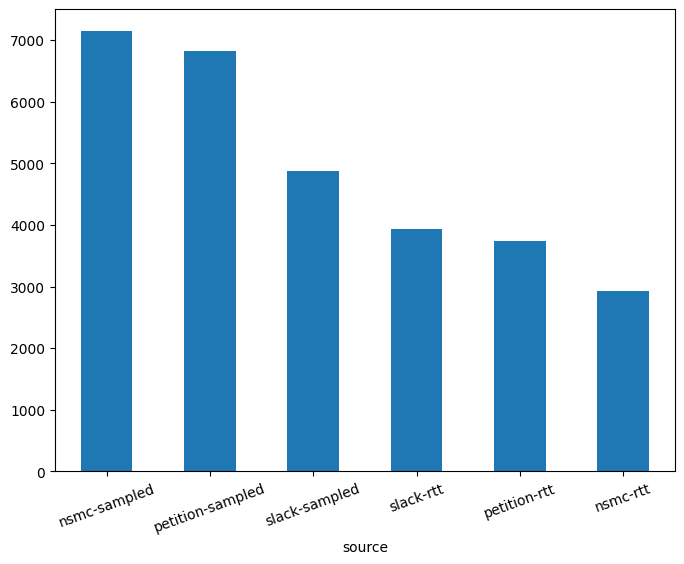

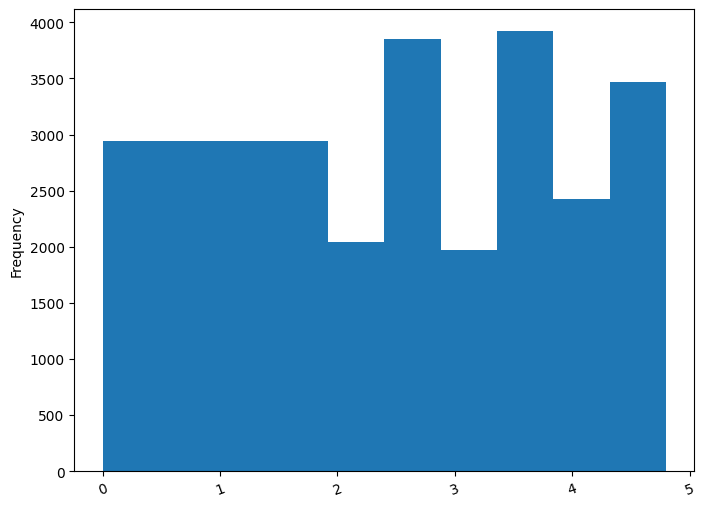

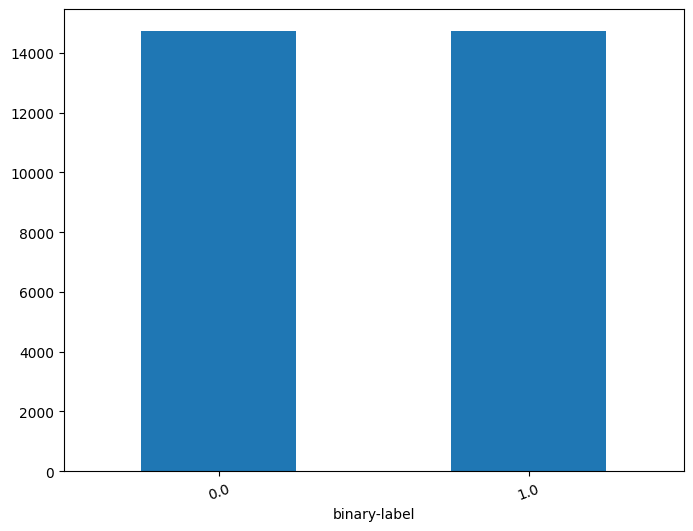

In [12]:
draw_graph(augmented_df)

In [13]:
augmented_df.sample(5)

,id,source,sentence_1,sentence_2,label,binary-label
23574,boostcamp-sts-v1-train-021,petition-rtt,김기덕 조재현 성폭행 철저히 수사해주세요!,김기덕·조재현 성폭행 의혹 철저히 수사하라!,4.2,1.0
27494,boostcamp-sts-v1-train-2481,petition-sampled,이명박출국금지청원합니다.,이명박출국금지요청합니다.,4.6,1.0
24229,boostcamp-sts-v1-train-2716,nsmc-rtt,의상 덕분에 눈도 즐거웠고 시대표적 배경인 남북전쟁에 대해서도 잘 표현해준 것 같아요.,의상 덕분에 눈이 즐거웠고 남북전쟁의 역사적 배경을 잘 표현한 것 같아요.,4.2,1.0
11398,boostcamp-sts-v1-train-8641,petition-sampled,공매도 세력 처벌해야,공매도 없어져야 합니다,1.8,0.0
12916,boostcamp-sts-v1-train-8594,nsmc-rtt,나카시마 미카 비주얼 아니였음 ㅋㅋㅋ 진짜 큰일날뻔 ㅠㅠ,나카시마 미카 비쥬얼 별로네 ㅋㅋ 진짜 재앙이겠다 ㅠㅠ,2.2,0.0


In [14]:
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

In [15]:
df.sample(5)

,id,source,sentence_1,sentence_2,label,binary-label
1074,boostcamp-sts-v1-train-1074,slack-rtt,<PERSON> 와~ 촉있는데요~,<PERSON> 와~ 만지셨군요~,0.4,0.0
4395,boostcamp-sts-v1-train-4395,slack-sampled,사실 제 반팔도 우리 회사 반팔입니다!,4:1 우리 회사위 웃음을 주셨던 ㅎㅎㅎ 우리 회사 로고송도 기대됩니다!!!,0.6,0.0
7277,boostcamp-sts-v1-train-7277,nsmc-sampled,제가 본 영화 중에서 제일 재밌었어요,내가 본 영화중에서 제일 좋았다.,3.8,1.0
2988,boostcamp-sts-v1-train-2988,slack-sampled,차주 월요일에 올듯!,사진은 화요일의 아침,0.0,0.0
2056,boostcamp-sts-v1-train-2056,nsmc-sampled,영화관에서 돈 주고 봐서 낮게 준거야?,이런것도 영화관에서 상영을해?ㅋ;,1.2,0.0


In [16]:
augmented_df.sample(5)

,id,source,sentence_1,sentence_2,label,binary-label
17257,boostcamp-sts-v1-train-2589,nsmc-rtt,영화 극장가에서 개봉 본건 행운이었죠...,이 영화를 극장에서 개봉했을 때 운이 좋았는지...,2.6,1.0
3974,boostcamp-sts-v1-train-3426,slack-sampled,담에 커피나 맥주 담력 연령 비어 한잔 하면서 이야기 나누어요 ㅎ,담에 또 이야기 많이 나눠요ㅎㅎㅎ,3.0,1.0
20272,boostcamp-sts-v1-train-849,petition-sampled,소년법폐지!!!!!,소년법 폐지해주세요!!!!!!,4.2,1.0
25795,boostcamp-sts-v1-train-1584,petition-rtt,"외국인 범죄를 국가별, 종교별, 범죄유형별로 통계해 주시고 외국인범죄에 대한 경각심...","국가별, 종교별, 범죄유형별 해외범죄 통계를 유지하고 해외범죄 경각심을 높이기 위해...",3.8,1.0
28445,boostcamp-sts-v1-train-6090,slack-rtt,싸인 코싸인 비유가 너무 격 찰떡이네 점 요 ㅎㅎ,기호와 코사인 은유는 너무 완벽합니다.,3.2,1.0


In [17]:
augmented_df.to_csv('../augmented_train.csv')